In [1]:
import os
from pathlib import Path
import pickle
from copy import deepcopy

from gears import PertData
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sns.set_style("whitegrid")

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


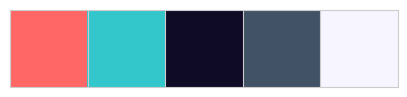

In [2]:
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

colors = ["#33C7CC", "white", "#FF6666"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

In [3]:
def bulk_data(pert_data, perturbation_dict):

    perturbation_dict = deepcopy(perturbation_dict)

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()
    data = data - data.loc['ctrl']
    data = data.drop('ctrl')

    train_val_samples = perturbation_dict['train'] + perturbation_dict['val']
    train_val_samples.remove('ctrl')
    test_samples = perturbation_dict['test']

    data_train_val = data.loc[train_val_samples]
    data_test = data.loc[test_samples]
    return data_train_val, data_test

In [4]:
def plot_heatmap(trainval, test, ds_name):
    
    colors = ["#33C7CC", "white", "#FF6666"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    print("Number of training and validation samples:", len(trainval))
    print("Number of test samples:", len(test))

    corr_between_all_samples = np.corrcoef(trainval.values, test.values)
    corr_lower_triangle = np.median(corr_between_all_samples[np.tril_indices(corr_between_all_samples.shape[0], k=-1)])
    print(f"Lower triangle median correlation: {corr_lower_triangle:.3f}")
    corr_test_train_samples = np.median(corr_between_all_samples[trainval.shape[0]:, :test.shape[0]].flatten())
    print(f"Test-train median correlation: {corr_test_train_samples:.3f}")

    fig, ax = plt.subplots()

    sns.heatmap(corr_between_all_samples, cmap=custom_cmap, center=0, vmin=-1, vmax=1, ax=ax)
    ax.axhline(y=len(trainval), color='black', linewidth=2)
    ax.axvline(x=len(trainval), color='black', linewidth=2)
    ax.set_title(f"DE correlation between training and test on\n{ds_name} pseudo-bulk dataset")
    ax.set_xlabel("Perturbed genes")
    ax.set_ylabel("Perturbed genes")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [5]:
def calc_ctrl_pert_condition_cnt(adata):
    ctrl_cnt = sum(adata.obs.condition == 'ctrl')
    pert_cnt = sum(adata.obs.condition != 'ctrl')
    cond_cnt = adata.obs.condition.nunique() - 1

    return ctrl_cnt, pert_cnt, cond_cnt

In [6]:
BASE_DIR = Path(os.getcwd()).resolve().parent / "data"

## Dataset biases on bulk

### Adamson

In [7]:
pert_data_adamson = PertData(BASE_DIR)
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

perturbation_dict_adamson = deepcopy(pert_data_adamson.set2conditions)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


In [10]:
bulk_adamson_train_val, bulk_adamson_test = bulk_data(
    pert_data=pert_data_adamson,
    perturbation_dict=perturbation_dict_adamson
)

Number of training and validation samples: 64
Number of test samples: 22
Lower triangle median correlation: 0.662
Test-train median correlation: 0.653


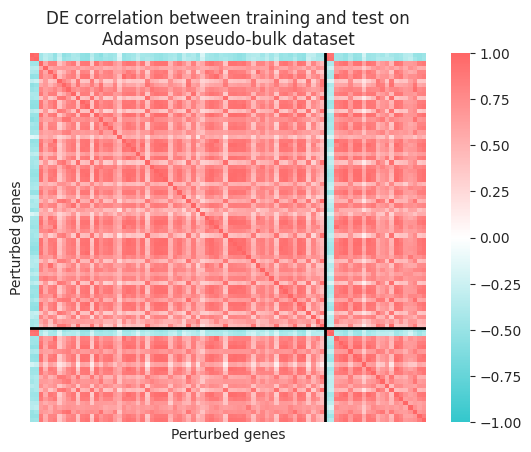

In [11]:
plot_heatmap(bulk_adamson_train_val, bulk_adamson_test, "Adamson")

## Norman

In [12]:
pert_data_norman = PertData(BASE_DIR)
pert_data_norman.load(data_name='norman')
pert_data_norman.prepare_split(split="simulation", seed=1)

perturbation_dict_norman = deepcopy(pert_data_norman.set2conditions)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [14]:
bulk_norman_train_val, bulk_norman_test = bulk_data(
    pert_data=pert_data_norman,
    perturbation_dict=perturbation_dict_norman
)

Number of training and validation samples: 167
Number of test samples: 116
Lower triangle median correlation: 0.273
Test-train median correlation: 0.256


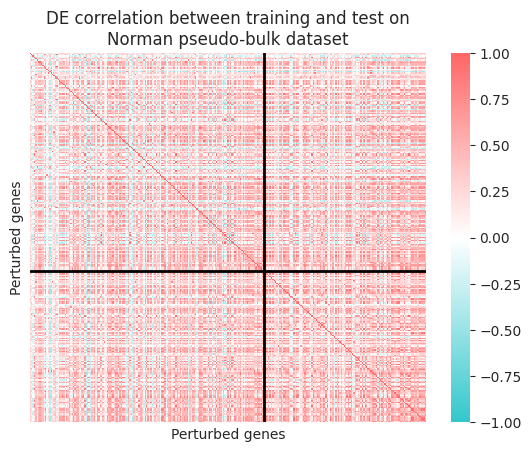

In [15]:
plot_heatmap(bulk_norman_train_val, bulk_norman_test, "Norman")

## Replogle

In [24]:
from gears.utils import zip_data_download_wrapper

In [31]:
zip_data_download_wrapper(
    "https://dataverse.harvard.edu/api/access/datafile/7458695",
    "../test_data",
    data_path="../test_data",
)

Downloading...
100%|██████████| 670M/670M [00:41<00:00, 16.2MiB/s] 
Extracting zip file...
Done!


In [35]:
data_path="../test_data/replogle_k562_essential"

In [36]:
adata_path = os.path.join(data_path, 'perturb_processed.h5ad')
adata = sc.read_h5ad(adata_path)
dataset_name = data_path.split('/')[-1]
dataset_path = data_path

In [37]:
adata

AnnData object with n_obs × n_vars = 162751 × 5000
    obs: 'condition', 'cell_type', 'cov_drug_dose_name', 'dose_val', 'control', 'condition_name'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [40]:
adata.obs

,condition,cell_type,cov_drug_dose_name,dose_val,control,condition_name
cell_barcode,,,,,,
AAACCCAAGAAGCCAC-34,UBL5+ctrl,K562,K562_UBL5+ctrl_1+1,1+1,0,K562_UBL5+ctrl_1+1
AAAGGATTCTCTCGAC-42,UBL5+ctrl,K562,K562_UBL5+ctrl_1+1,1+1,0,K562_UBL5+ctrl_1+1
AACGGGAGTAATGATG-25,UBL5+ctrl,K562,K562_UBL5+ctrl_1+1,1+1,0,K562_UBL5+ctrl_1+1
AAGAACAAGCTAGATA-35,UBL5+ctrl,K562,K562_UBL5+ctrl_1+1,1+1,0,K562_UBL5+ctrl_1+1
AAGACTCTCTATTGTC-33,UBL5+ctrl,K562,K562_UBL5+ctrl_1+1,1+1,0,K562_UBL5+ctrl_1+1
...,...,...,...,...,...,...
TTATTGCCACGTGAGA-26,RPS2+ctrl,K562,K562_RPS2+ctrl_1+1,1+1,0,K562_RPS2+ctrl_1+1
TTGTTGTTCATGGATC-47,RPS2+ctrl,K562,K562_RPS2+ctrl_1+1,1+1,0,K562_RPS2+ctrl_1+1
TTTCACATCTCTTCAA-41,RPS2+ctrl,K562,K562_RPS2+ctrl_1+1,1+1,0,K562_RPS2+ctrl_1+1


In [38]:
pert_data_replogle = PertData("../test_data")
pert_data_replogle.load(data_path="../test_data/replogle_k562_essential")

Creating pyg object for each cell in the data...
  0%|          | 0/1093 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
pert_data_replogle = PertData(BASE_DIR)
pert_data_replogle.load(data_path=str(BASE_DIR / 'replogle_k562_essential'))
pert_data_replogle.prepare_split(split="simulation", seed=1)
perturbation_dict_replogle = deepcopy(pert_data_replogle.set2conditions)


Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


In [22]:
bulk_replogle_train_val, bulk_replogle_test = bulk_data(
    pert_data=pert_data_replogle,
    perturbation_dict=perturbation_dict_replogle
)

Number of training and validation samples: 819
Number of test samples: 273
Lower triangle median correlation: 0.117
Test-train median correlation: 0.123


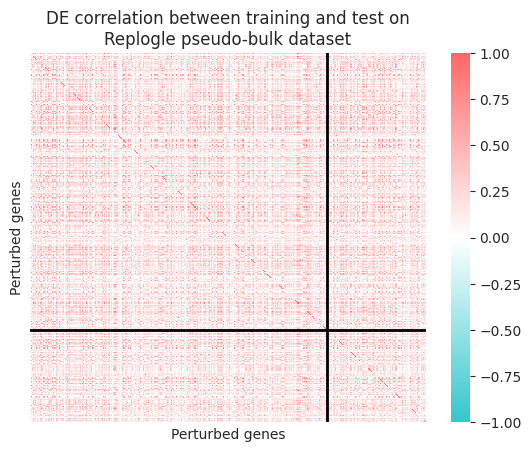

In [ ]:
plot_heatmap(bulk_replogle_train_val, bulk_replogle_test, "Replogle")

## SC and conditions

In [ ]:
adata_adamson = sc.read_h5ad(BASE_DIR / "adamson/perturb_processed.h5ad")
adata_norman = sc.read_h5ad(BASE_DIR / "norman/perturb_processed.h5ad")
adata_replogle = sc.read_h5ad(BASE_DIR / "replogle_k562_essential/perturb_processed.h5ad")

In [ ]:
df = pd.DataFrame({
    'cnt_val': calc_ctrl_pert_condition_cnt(adata_adamson) + calc_ctrl_pert_condition_cnt(adata_norman) + calc_ctrl_pert_condition_cnt(adata_replogle),
    'cnt': ['control', 'perturbed', 'perturbation'] * 3,
    'ds': ["Adamson"] * 3 + ["Norman"] * 3 + ["Replogle"] * 3
})
df["cnt_val_log"] = np.log10(df["cnt_val"])

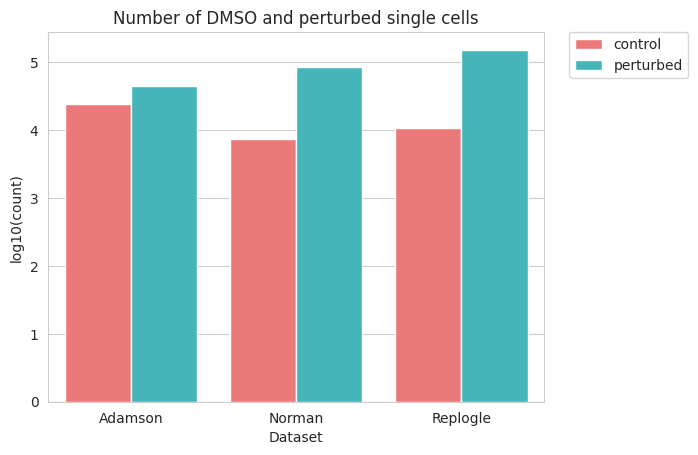

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Number of DMSO and perturbed single cells")
ax.set_xlabel("Dataset")
ax.set_ylabel("log10(count)")
sns.barplot(df[df.cnt != "perturbation"], x="ds", y="cnt_val_log", hue="cnt", ax=ax)
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

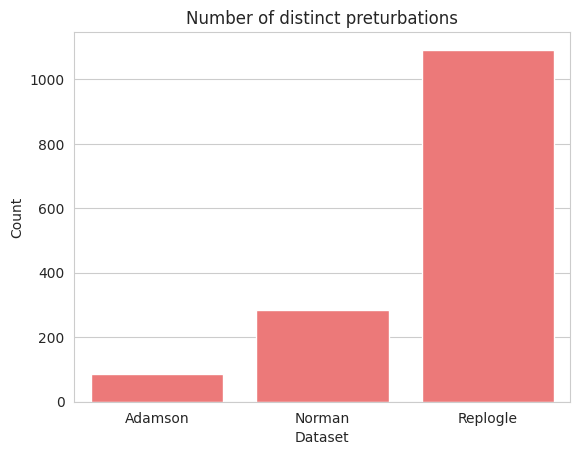

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Number of distinct preturbations")
ax.set_xlabel("Dataset")
ax.set_ylabel("Count")
sns.barplot(df[df.cnt == "perturbation"], x="ds", y="cnt_val", ax=ax)
plt.show()